<a href="https://colab.research.google.com/github/jhchang/Forecasting-Solar-Irradiance/blob/main/04_Walkforward_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ⏩ Walk-Forward Validation for GHI Forecasting

In this notebook, we apply **walk-forward validation (WFV)** to evaluate the performance of an `XGBRegressor` model for predicting **Global Horizontal Irradiance (GHI)** at short time horizons (1 hour and 3 hours ahead).

---

### 📌 Why Walk-Forward Validation?

Traditional train/test splits don't work well for **time series data**, where the order of observations matters. Instead, we use **walk-forward validation**, a technique that mimics real-world forecasting:

> ⏱ At each step, the model is trained on all data **up to time _t_**, and tested on time **_t+H_**, where _H_ is the forecast horizon (e.g., 1 or 3 hours).

This strategy helps us:
- Prevent **data leakage** (future information leaking into the past)
- Accurately assess how the model would perform in **live deployment**
- Detect performance shifts across different **seasons or conditions**

---

### 🔁 How It Works

For each prediction window:
1. The model is trained on all historical data up to time _t_
2. A prediction is made for time _t+H_
3. The window moves forward by one time step, and steps 1–2 repeat

This creates a sequence of **rolling forecasts**, one for each time step in the test period, simulating how the model would perform in a production environment.

---

### 🎯 Evaluation Horizons

We run walk-forward validation for two forecast horizons:

- ⏱ **1-hour ahead** – captures short-term GHI fluctuations relevant for **solar tracking and grid smoothing**
- ⏱ **3-hour ahead** – supports **energy storage planning** and short-term **load balancing**

Each model is evaluated using:
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)

---

### ⚙️ Model

We use an `XGBRegressor` from `xgboost`, trained on:
- Lag features (past GHI, temperature, etc.)
- Time-of-day and seasonal features (e.g., `hour_sin`, `dayofyear_cos`)
- Weather covariates from NASA POWER (e.g., cloud cover, wind speed)

---

> This notebook provides a strong non-deep-learning baseline and builds intuition about GHI dynamics before switching to neural models like TFT.



### Why use XBG instead of Random Forests?

While Random Forests performed better overall, they are known to overfit data and not model non linearities well. XBG might be able to predict values in the GHI graph that are non seasonal.

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Replace with your file path
file_path = "/content/drive/MyDrive/datasets/augmented_weather_data.csv"

df = pd.read_csv(file_path, parse_dates=True, index_col=0)

## Walkforward Validation

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def walk_forward_with_residuals(df, model, forecast_horizon=1, step_size=72, window_size=1000):
    df = df.copy()
    df = df.sort_index()

    metrics = []
    residuals = []

    forecast_timedelta = pd.Timedelta(hours=forecast_horizon)

    features = [col for col in df.columns if col not in ['TARGET', 'TARGET_1h', 'TARGET_3h']]

    for i in range(0, len(df) - window_size - forecast_horizon + 1, step_size):
        train = df.iloc[i:i + window_size]
        test = df.iloc[i + window_size:i + window_size + forecast_horizon]

        if len(test) == 0 or len(train) == 0:
            continue

        X_train = train[features]
        y_train = train['TARGET']
        X_test = test[features]
        y_test = test['TARGET']

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        # Compute metrics for this fold
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        metrics.append({
            'train_end': train.index[-1],
            'test_start': test.index[0],
            'test_end': test.index[-1],
            'MAE': mae,
            'RMSE': rmse
        })

        # Store detailed residuals
        test_copy = test.copy()
        test_copy['Predicted'] = preds
        test_copy['Residual'] = y_test - preds
        test_copy['AbsError'] = np.abs(test_copy['Residual'])

        # Keep only relevant columns for residual diagnostics
        keep_cols = ['TARGET', 'Predicted', 'Residual', 'AbsError',
                     'hour', 'month', 'ALLSKY_KT', 'ALLSKY_SFC_SW_DIFF']
        for col in keep_cols:
            if col not in test_copy.columns:
                test_copy[col] = np.nan  # fill missing diagnostics safely

        residuals.append(test_copy[keep_cols])

    print(f"Total windows evaluated: {len(metrics)}")
    metrics_df = pd.DataFrame(metrics)
    residuals_df = pd.concat(residuals)

    return metrics_df, residuals_df

'\nimport pandas as pd\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error\nimport numpy as np\n\ndef walk_forward_validation(df, model, forecast_horizon=1, step_size=72, window_size=1000):\n    df = df.copy()\n    df = df.sort_index()\n\n    results = []\n\n    forecast_timedelta = pd.Timedelta(hours=forecast_horizon)\n\n    features = [col for col in df.columns if col not in [\'TARGET\', \'TARGET_1h\', \'TARGET_3h\']]\n\n    for i in range(0, len(df) - window_size - forecast_horizon + 1, step_size):\n        train = df.iloc[i:i + window_size]\n        test = df.iloc[i + window_size:i + window_size + forecast_horizon]\n\n        if len(test) == 0 or len(train) == 0:\n            continue\n\n        X_train = train[features]\n        y_train = train[\'TARGET\']\n        X_test = test[features]\n        y_test = test[\'TARGET\']\n\n        model.fit(X_train, y_train)\n        preds = model.predict(X_test)\n\n        mae = mean_absolute_error(y_test, preds)\n        rmse

In [ ]:
df['TARGET_1h'] = df['ALLSKY_SFC_SW_DWN'].shift(-1)
df['TARGET_3h'] = df['ALLSKY_SFC_SW_DWN'].shift(-3)


## 🌘 Nighttime GHI = Easy 0s → Inflated Model Performance

At night:

- GHI is zero by definition (no sunlight).
- Most models (even dumb ones) can "guess" 0 and be perfectly right.
- This artificially lowers MAE/RMSE, making the model seem better than it actually is.

✅ What we should do:

To get a more honest view of model quality, filter out the night hours:
1. Filter to daylight hours:
2. Recompute metrics only on daytime data:

In [ ]:
df_daylight = df[df["is_daylight"] == 1]


In [ ]:
df_1h = df_daylight.dropna(subset=['TARGET_1h']).copy()
df_1h['TARGET'] = df_1h['TARGET_1h']

df_3h = df_daylight.dropna(subset=['TARGET_3h']).copy()
df_3h['TARGET'] = df_3h['TARGET_3h']


In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)

results_1h, residuals_1h = walk_forward_with_residuals(df_1h, model, forecast_horizon=1)
results_3h, residuals_3h = walk_forward_with_residuals(df_3h, model, forecast_horizon=3)



Total windows evaluated: 174
Total windows evaluated: 174


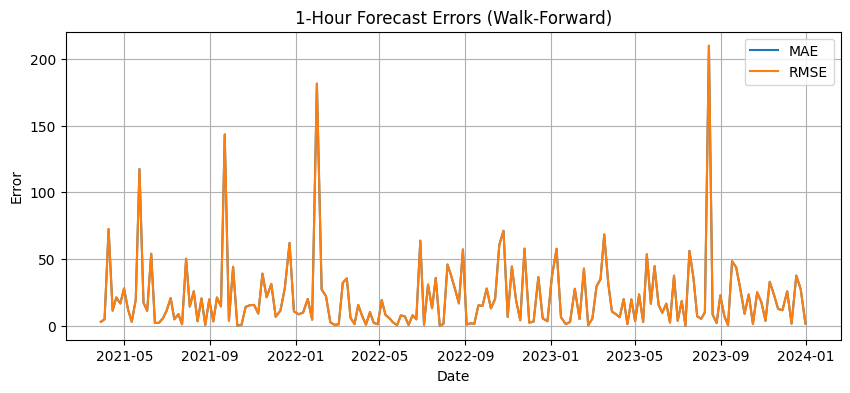

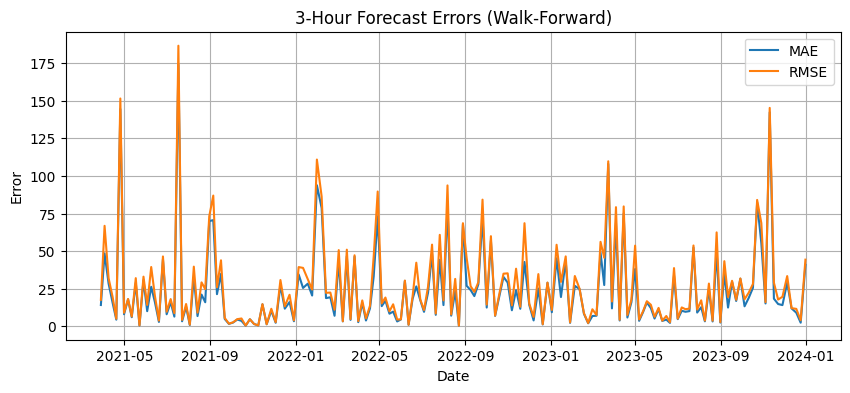

In [ ]:
import matplotlib.pyplot as plt

def plot_results(results_df, title):
    plt.figure(figsize=(10, 4))
    plt.plot(results_df["test_start"], results_df["MAE"], label='MAE')
    plt.plot(results_df["test_start"], results_df["RMSE"], label='RMSE')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_results(results_1h, "1-Hour Forecast Errors (Walk-Forward)")
plot_results(results_3h, "3-Hour Forecast Errors (Walk-Forward)")


<Axes: title={'center': 'Average Abs Error by Month'}, xlabel='month'>

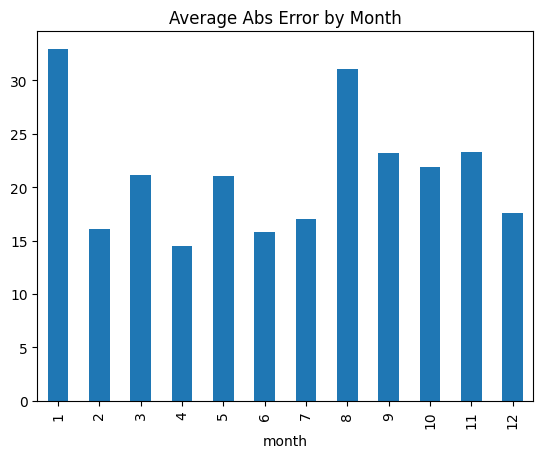

In [ ]:
monthly_errors = residuals_1h.groupby("month")["AbsError"].mean()
monthly_errors.plot(kind="bar", title="Average Abs Error by Month")


<Axes: title={'center': 'Average Abs Error by Hour'}, xlabel='hour'>

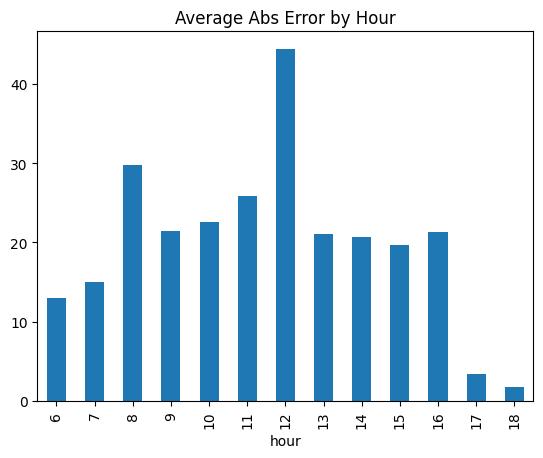

In [ ]:
hourly_errors = residuals_1h.groupby("hour")["AbsError"].mean()
hourly_errors.plot(kind="bar", title="Average Abs Error by Hour")


/tmp/ipython-input-61-3674747978.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cloud_errors = residuals_1h.groupby("sky_condition")["AbsError"].mean()


<Axes: title={'center': 'Abs Error by Sky Condition'}, xlabel='sky_condition'>

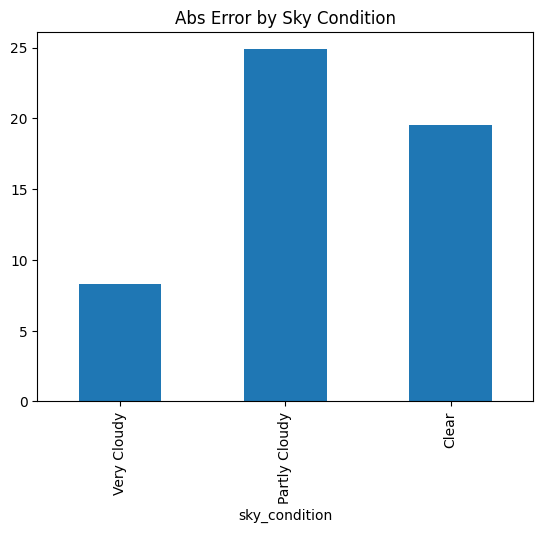

In [ ]:
residuals_1h["sky_condition"] = pd.cut(residuals_1h["ALLSKY_KT"],
                                     bins=[0, 0.3, 0.6, 1.0],
                                     labels=["Very Cloudy", "Partly Cloudy", "Clear"])

cloud_errors = residuals_1h.groupby("sky_condition")["AbsError"].mean()
cloud_errors.plot(kind="bar", title="Abs Error by Sky Condition")


These plots give you **very clear, actionable insights** about where and why your model struggles — and what to improve next.

---

## 🔍 Key Insights from our Plots

### 📆 1. **Error by Month**

* ❗️**January and August** have the highest average absolute error.
* Possibly due to:

  * **January**: rapid cloud cover changes, lower sun angle, or less training data.
  * **August**: **summer haze/dust**, partial clouds, or seasonal monsoon edge effects.

**→ What to do:**

* Add **"month\_sin/cos" cyclical encodings** or month interactions to model.
* Consider training a **seasonal model ensemble** (separate models for winter/summer).

---

### 🕑 2. **Error by Hour**

* ❗️Spikes **at 12 PM** and high at 8 AM and 11 AM.
* This may indicate:

  * Sharp changes in irradiance due to **passing clouds**.
  * **Overprediction around noon** due to expected peak GHI vs real variability.

---

### 🌥️ 3. **Error by Sky Condition**

* ❗️**Partly cloudy skies** have the worst error.
* This makes sense — clear skies are predictable, and very cloudy skies are consistently low GHI.
* Partly cloudy = **high unpredictability** (shadow flicker, diffuse light).

**→ What to do:**

* Consider **predicting uncertainty**, e.g., using quantile regression or prediction intervals.
* Try **classifying sky condition first**, then using different regressors per category.
* Use `ALLSKY_SFC_SW_DIFF` and `ALLSKY_KT` together as volatility proxies.

---
